# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename, load_parquet_subset
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.aggregate.filter import (
    query_filter,
    perturbation_filter,
    missing_values_filter,
    intensity_filter,
)
from lib.aggregate.align import (
    prepare_alignment_data,
    pca_variance_plot,
    embed_by_pca,
    tvn_on_controls,
)
from lib.aggregate.aggregate import aggregate
from lib.aggregate.eval_aggregate import (
    nas_summary,
    plot_feature_distributions,
    summarize_cell_data,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

## <font color='red'>SET PARAMETERS</font>

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL`: Well identifier used for testing configuration

In [3]:
TEST_PLATE = 1
TEST_WELL = "A1"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=50000)
display(cell_data)

print("First 20 columns; use to set parameters below.")
for index, col in enumerate(cell_data.columns[:20]):
    print(index, col)

Reading first 50,000 rows from /lab/cheeseman_ops/brieflow-screens/denali-analysis/analysis/analysis_root/merge/parquets/P-1_W-A1__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1045,437,1478.403947,1481.714474,243,265,100.607843,670.117647,...,0,0.000000,48.564099,54.586397,164.116340,0,0.000000,48.615252,55.257173,159.483845
1,1,A1,401,494,1477.766431,1478.877654,101,302,100.089552,669.910448,...,1,0.065657,45.153871,62.255752,106.221846,1,0.037791,40.275758,56.068075,115.752777
2,1,A1,1502,507,1480.628283,1477.384343,354,280,100.674419,99.806202,...,0,0.000000,50.811479,74.397288,151.581091,0,0.000000,52.963143,70.225474,167.657553
3,1,A1,595,482,1480.676399,1482.874696,154,228,100.764706,670.764706,...,2,0.229299,37.000701,51.898329,172.518929,2,0.068627,38.735022,47.030219,157.402576
4,1,A1,1479,613,1477.695030,1481.850904,365,352,99.764045,671.494382,...,0,0.000000,57.800029,61.225938,139.073759,0,0.000000,62.404446,63.974515,134.672172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A1,1569,653,1728.326458,1597.428876,369,2317,732.563218,131.034483,...,0,0.000000,45.356211,58.364715,109.133333,0,0.000000,46.235990,58.631440,164.461494
49996,1,A1,941,492,1684.513544,1663.389391,233,303,150.982143,716.116071,...,0,0.000000,81.068643,88.727647,76.725794,0,0.000000,72.599442,80.938046,83.413197
49997,1,A1,911,494,1207.529769,1445.108141,220,1858,601.915254,91.203390,...,0,0.000000,45.038072,63.114432,65.686930,0,0.000000,45.787703,72.450334,59.700141
49998,1,A1,391,559,1410.022422,1745.634978,96,277,81.890411,736.397260,...,0,0.000000,52.224732,71.559702,167.369728,0,0.000000,52.909050,71.546328,169.621047


First 20 columns; use to set parameters below.
0 plate
1 well
2 tile
3 cell_0
4 i_0
5 j_0
6 site
7 cell_1
8 i_1
9 j_1
10 distance
11 fov_distance_0
12 fov_distance_1
13 sgRNA_0
14 gene_symbol_0
15 mapped_single_gene
16 channels_min
17 nucleus_DAPI_int
18 nucleus_COXIV_int
19 nucleus_CENPA_int


## <font color='red'>SET PARAMETERS</font>

### Split cells into classes

- `CLASSIFIER_PATH`: Path to pickled Python object that can take a cell data dataframe and output cell classes
- `FIRST_FEATURE`: Name of first feature in cell data (see first 20 cols above). Usually `nucleus_DAPI_int`

### Evaluate splitting

- `COLLAPSE_COLS`: Columns to collapse on when creating a summary of cell counts.
- `MONTAGE_CHANNEL`: Channel to use for montage generation. Usually `DAPI`

**Note**: Any Python packages necessary for a custom loaded cell classifier must be imported here and in `brieflow/workflow/scripts/aggregate/create_datasets.py`

In [5]:
CLASSIFIER_PATH = "config/naive_mitotic_classifier.pkl"
FIRST_FEATURE = "nucleus_DAPI_int"
MONTAGE_CHANNEL = "DAPI"
COLLAPSE_COLS = ["sgRNA_0", "gene_symbol_0"]

"""
IMPORT PACKAGES NECESSARY FOR CLASSIFIER
"""
from sklearn.preprocessing import RobustScaler
import numpy as np

Cell class counts:
class
interphase    49542
mitotic         458
Name: count, dtype: int64

Cell class confidences:


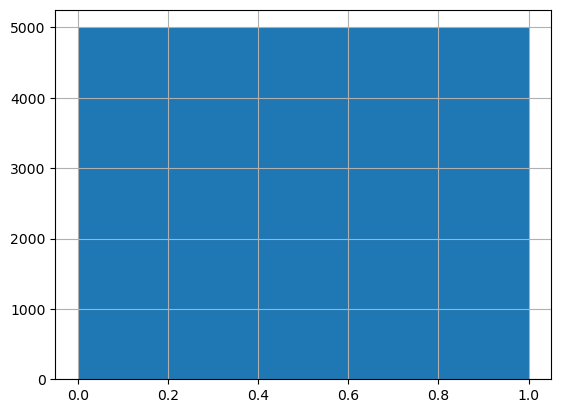

In [6]:
classifier = CellClassifier.load(CLASSIFIER_PATH)
cell_data = classifier.classify_cells(cell_data, FIRST_FEATURE)

# Create config var for cell classes
CELL_CLASSES = list(cell_data["class"].unique())

print("Cell class counts:")
print(cell_data["class"].value_counts())

print("\nCell class confidences:")
cell_data["confidence"].hist()
plt.show()

In [7]:
# classified_cell_data = cell_data.copy()
# classified_cell_data = add_filenames(classified_cell_data, ROOT_FP)

# # Create a dictionary of DataFrames for each cell class
# cell_class_dfs = {
#     cell_class: classified_cell_data[classified_cell_data["class"] == cell_class]
#     for cell_class in CELL_CLASSES
# }

# # Define sorting directions and titles
# title_templates = {
#     True: "Lowest Confidence {cell_class} Cells - {channel}",
#     False: "Highest Confidence {cell_class} Cells - {channel}",
# }

# # Generate montages dynamically
# montages, titles = [], []
# for cell_class, cell_df in cell_class_dfs.items():
#     for ascending in [True, False]:
#         montage = create_cell_montage(
#             cell_data=cell_df,
#             channels=config["phenotype"]["channel_names"],
#             selection_params={
#                 "method": "sorted",
#                 "sort_by": "confidence",
#                 "ascending": ascending,
#             },
#         )[MONTAGE_CHANNEL]
#         montages.append(montage)
#         titles.append(
#             title_templates[ascending].format(
#                 cell_class=cell_class, channel=MONTAGE_CHANNEL
#             )
#         )

# # Determine figure size dynamically
# num_rows = len(CELL_CLASSES)
# fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))

# # Display montages
# for ax, title, montage in zip(axes.flat, titles, montages):
#     ax.imshow(montage, cmap="gray")
#     ax.set_title(title, fontsize=14)
#     ax.axis("off")

# print("Montages of cell classes:")
# plt.tight_layout()
# plt.show()

# print("Split cell data summary:")
# summary_df = summarize_cell_data(cell_data, CELL_CLASSES, COLLAPSE_COLS)
# summary_df

## <font color='red'>SET PARAMETERS</font>

### Perturbation filtering

- `FILTER_QUERIES`: Queries to use for custom filtering; ex: `["mapped_single_gene == False", "cell_quality_score > 0.8"]`. Can be left as `None` for no filtering.
- `PERTURBATION_NAME_COL`: Name of column used to identify perturbation

Found 22804 cells with assigned perturbations
Unique populations: 4600


,column,percent_na
60,cytoplasm_DAPI_mean_frac_0,0.683301
61,cytoplasm_COXIV_mean_frac_0,0.683301
62,cytoplasm_CENPA_mean_frac_0,0.683301
63,cytoplasm_WGA_mean_frac_0,0.683301
64,cytoplasm_DAPI_mean_frac_1,0.642168
65,cytoplasm_COXIV_mean_frac_1,0.642168
66,cytoplasm_CENPA_mean_frac_1,0.642168
67,cytoplasm_WGA_mean_frac_1,0.642168
72,cytoplasm_DAPI_radial_cv_0,0.683301
73,cytoplasm_COXIV_radial_cv_0,0.683301


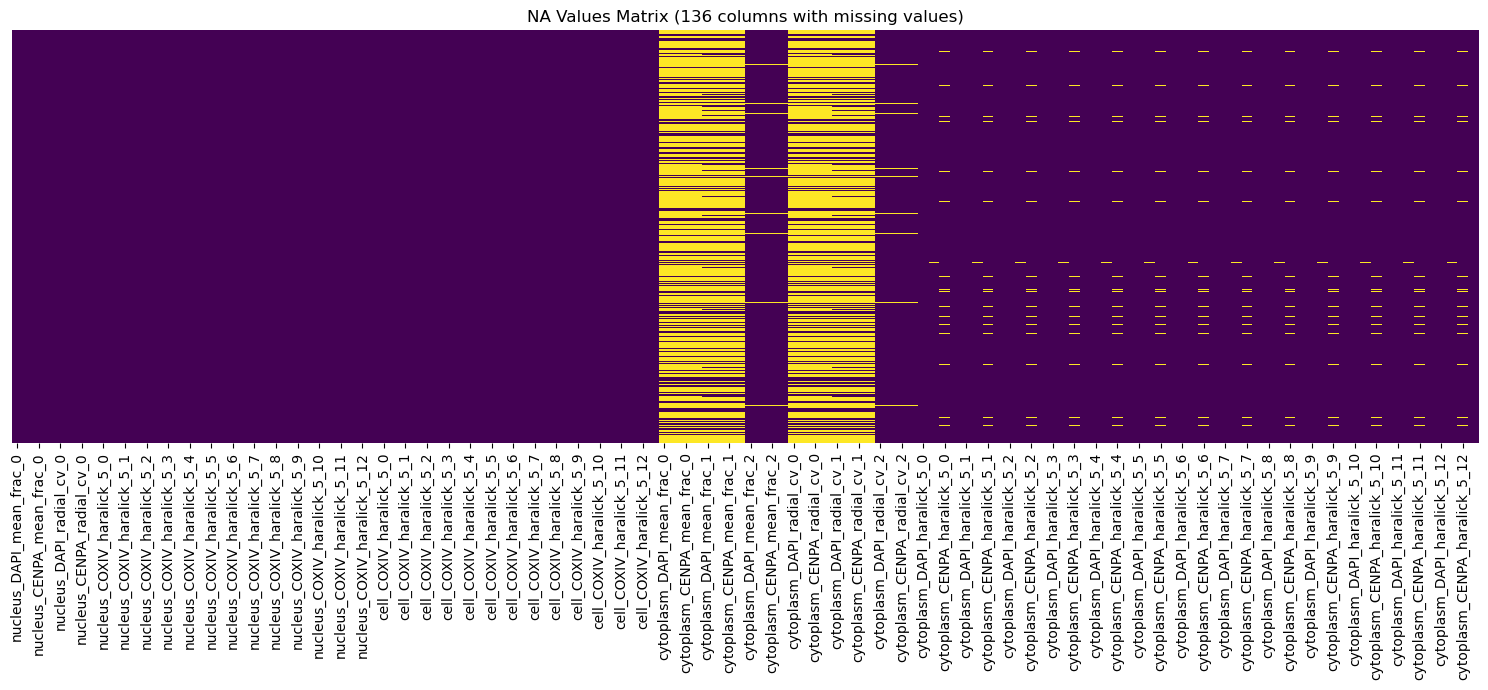

In [8]:
FILTER_QUERIES = None
PERTURBATION_NAME_COL = "gene_symbol_0"

query_filtered = query_filter(cell_data, FILTER_QUERIES)

perturbation_filtered = perturbation_filter(
    cell_data, PERTURBATION_NAME_COL
)
print(f"Unique populations: {perturbation_filtered[PERTURBATION_NAME_COL].nunique()}")

sumamry_df, fig = nas_summary(perturbation_filtered)
sumamry_df[sumamry_df["percent_na"] > 0.1]

## <font color='red'>SET PARAMETERS</font>

### Missing value filtering

- `DROP_COLS_THRESHOLD`: Threshold of NA values above which an entire column is dropped. Usually `0.1`
- `DROP_ROWS_THRESHOLD`: Threshold of NA values above which an entire row is dropped. Usually `0.01`
- `IMPUTE`: Whether or not to impute remaining missing values. Usually `True`

**Note**: All NAs must be dropped or imputed to perform feature alignment.

In [9]:
DROP_COLS_THRESHOLD = 0.1
DROP_ROWS_THRESHOLD = 0.01
IMPUTE = True

In [10]:
# Filter by missing values
missing_values_filtered = missing_values_filter(
    perturbation_filtered,
    FIRST_FEATURE,
    drop_cols_threshold=DROP_COLS_THRESHOLD,
    drop_rows_threshold=DROP_ROWS_THRESHOLD,
    impute=True,
)

missing_values_filtered

Dropping 16 columns with ≥10.0% missing values
Dropped 198 rows with ≥1.0% missing values
Imputing 55 columns with remaining missing values using batched KNN
Imputing for batch 1 with 1000 NA rows
Imputing for batch 2 with 398 NA rows


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1502,507,1480.628283,1477.384343,354,280,100.674419,99.806202,...,0,0.000000,50.811479,74.397288,151.581091,0,0.000000,52.963143,70.225474,167.657553
1,1,A1,418,504,1476.375566,1478.313725,109,300,99.071429,99.107143,...,0,0.000000,47.670493,66.586354,164.723665,0,0.000000,47.284624,73.497381,172.358967
2,1,A1,1160,603,1480.918072,1475.887550,271,2073,670.875000,100.037500,...,0,0.000000,62.726815,64.024196,71.655919,0,0.000000,60.189160,68.498827,69.299229
3,1,A1,1185,548,1484.316222,1478.959617,300,228,101.153846,670.461538,...,0,0.000000,60.764439,61.220197,174.446417,0,0.000000,67.295378,68.514281,178.202148
4,1,A1,1448,558,1480.565083,1486.317149,351,1863,671.215385,103.030769,...,1,0.151515,39.718794,56.318906,71.871136,1,0.087719,39.535027,55.081105,79.910721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22601,1,A1,739,481,1238.569288,1611.002140,175,3930,1179.878049,704.317073,...,0,0.000000,66.606704,76.363891,152.518309,0,0.000000,67.750654,71.712917,157.404940
22602,1,A1,767,409,1417.819200,1212.444000,193,166,84.828947,603.684211,...,0,0.000000,64.283879,76.278725,31.763783,0,0.000000,71.271597,84.524829,30.062962
22603,1,A1,1569,653,1728.326458,1597.428876,369,2317,732.563218,131.034483,...,0,0.000000,45.356211,58.364715,109.133333,0,0.000000,46.235990,58.631440,164.461494
22604,1,A1,941,492,1684.513544,1663.389391,233,303,150.982143,716.116071,...,0,0.000000,81.068643,88.727647,76.725794,0,0.000000,72.599442,80.938046,83.413197


## <font color='red'>SET PARAMETERS</font>

### Intensity filtering

- `CONTAMINATION`: Expected proportion of outliers in dataset. Usually `0.01`

In [11]:
CONTAMINATION = 0.01

In [12]:
# Filter by intensity outliers
intesity_filtered = intensity_filter(
    missing_values_filtered,
    FIRST_FEATURE,
    config["phenotype"]["channel_names"],
    CONTAMINATION,
)

intesity_filtered

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1502,507,1480.628283,1477.384343,354,280,100.674419,99.806202,...,0,0.000000,50.811479,74.397288,151.581091,0,0.000000,52.963143,70.225474,167.657553
1,1,A1,418,504,1476.375566,1478.313725,109,300,99.071429,99.107143,...,0,0.000000,47.670493,66.586354,164.723665,0,0.000000,47.284624,73.497381,172.358967
2,1,A1,1160,603,1480.918072,1475.887550,271,2073,670.875000,100.037500,...,0,0.000000,62.726815,64.024196,71.655919,0,0.000000,60.189160,68.498827,69.299229
3,1,A1,1185,548,1484.316222,1478.959617,300,228,101.153846,670.461538,...,0,0.000000,60.764439,61.220197,174.446417,0,0.000000,67.295378,68.514281,178.202148
4,1,A1,1448,558,1480.565083,1486.317149,351,1863,671.215385,103.030769,...,1,0.151515,39.718794,56.318906,71.871136,1,0.087719,39.535027,55.081105,79.910721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22374,1,A1,739,481,1238.569288,1611.002140,175,3930,1179.878049,704.317073,...,0,0.000000,66.606704,76.363891,152.518309,0,0.000000,67.750654,71.712917,157.404940
22375,1,A1,767,409,1417.819200,1212.444000,193,166,84.828947,603.684211,...,0,0.000000,64.283879,76.278725,31.763783,0,0.000000,71.271597,84.524829,30.062962
22376,1,A1,1569,653,1728.326458,1597.428876,369,2317,732.563218,131.034483,...,0,0.000000,45.356211,58.364715,109.133333,0,0.000000,46.235990,58.631440,164.461494
22377,1,A1,941,492,1684.513544,1663.389391,233,303,150.982143,716.116071,...,0,0.000000,81.068643,88.727647,76.725794,0,0.000000,72.599442,80.938046,83.413197


## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `BATCH_COLS`: Which columns of metadata have batch-specific information. Usually `["plate", "well"]`.
- `CONTROL_KEY`: Name of perturbation in `PERTURBATION_NAME_COL` that indicates a control cell.

The following parameter is only needed if you want your controls to have different perturbation names. Otherwise, can leave this as `None`.
- `PERTURBATION_ID_COL`: Name of column that identifies unique perturbations.

In [13]:
BATCH_COLS = ["plate", "well"]
CONTROL_KEY = "nontargeting"
PERTURBATION_ID_COL = "sgRNA_0"

Number of components needed for 99.0% variance: 753
Shape of input data: (22379, 1651)
Shape of PCA transformed and reduced data: (22379, 753)
Top 10 pertubration counts:


gene_symbol_0
DCAF13         22
ZNF286B        22
KLF5           22
PHB            21
LMAN2          21
TIAL1          21
ARPC4-TTLL3    20
IREB2          20
GOSR2          20
TM2D2          20
Name: count, dtype: Int64

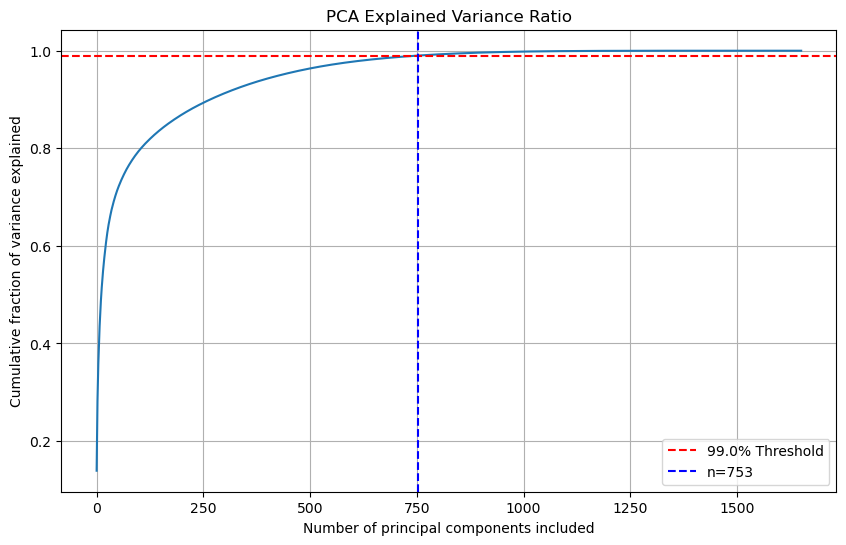

In [14]:
features, metadata = prepare_alignment_data(
    intesity_filtered, BATCH_COLS, FIRST_FEATURE, PERTURBATION_NAME_COL, CONTROL_KEY, PERTURBATION_ID_COL
)

pca_df_threshold, n_components, pca, fig = pca_variance_plot(
    features, variance_threshold=0.99
)

print("Top 10 pertubration counts:")
metadata[PERTURBATION_NAME_COL].value_counts()[:10]

## <font color='red'>SET PARAMETERS</font>

### Align and aggregate

- `PC_COUNT`: Number of principal components to use when creating embeddings with PCA (see figure above). Usually the amount of principal components needed to explain 95% of variance (see above).
- `AGG_METHOD`: Method used to aggregate features. Can be `mean` or `median`. Usually `mean`.

In [15]:
PC_COUNT = 753
AGG_METHOD = "mean"

Aligned feature distribtutions:


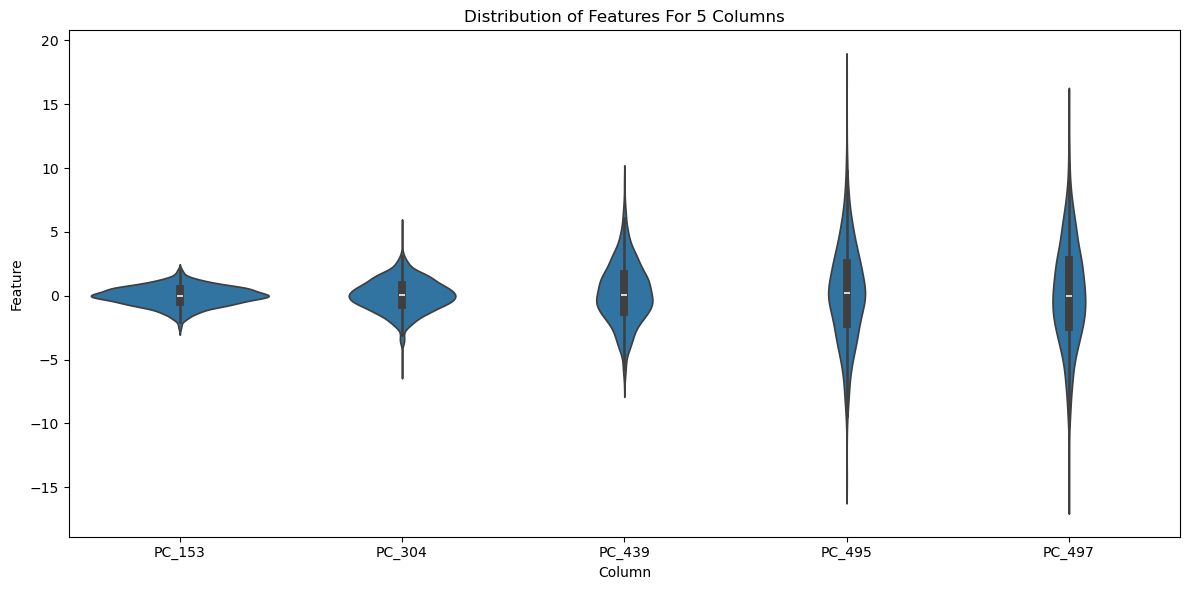

In [18]:
pca_embeddings = embed_by_pca(
    features, metadata, variance_or_ncomp=PC_COUNT, batch_col="batch_values"
)
tvn_normalized = tvn_on_controls(
    pca_embeddings, metadata, PERTURBATION_NAME_COL, CONTROL_KEY, "batch_values"
)

aggregated_embeddings, aggregated_metadata = aggregate(
    tvn_normalized, metadata, PERTURBATION_NAME_COL, AGG_METHOD
)

feature_columns = [f"PC_{i}" for i in range(tvn_normalized.shape[1])]

tvn_normalized_df = pd.DataFrame(
    tvn_normalized, index=metadata.index, columns=feature_columns
)
aligned_cell_data = pd.concat([metadata, tvn_normalized_df], axis=1)

aggregated_embeddings_df = pd.DataFrame(
    aggregated_embeddings, index=aggregated_metadata.index, columns=feature_columns
)
aggregated_cell_data = (
    pd.concat([aggregated_metadata, aggregated_embeddings_df], axis=1)
    .sort_values("cell_count", ascending=False)
    .reset_index(drop=True)
)

print("Aligned feature distribtutions:")
fig = plot_feature_distributions(aligned_cell_data, "PC_0", num_features=5)

## Add aggregate parameters to config file

In [19]:
# Add aggregate section
config["aggregate"] = {
    "classifier_path": CLASSIFIER_PATH,
    "first_feature": FIRST_FEATURE,
    "collapse_cols": COLLAPSE_COLS,
    "cell_classes": ["all"] + CELL_CLASSES,
    "filter_queries": FILTER_QUERIES,
    "perturbation_name_col": PERTURBATION_NAME_COL,
    "drop_cols_threshold": DROP_COLS_THRESHOLD,
    "drop_rows_threshold": DROP_ROWS_THRESHOLD,
    "impute": IMPUTE,
    "contamination": CONTAMINATION,
    "batch_cols": BATCH_COLS,
    "control_key": CONTROL_KEY,
    "perturbation_id_col": PERTURBATION_ID_COL,
    "pc_count": PC_COUNT,
    "agg_method": AGG_METHOD,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)